# Task 1. Playing with YoLO (from torch.hub)

In this task, you will download pre-trained weights for the YOLOv5 model and use it to detect objects in an image.
You will use the `torch.hub` library to download the model and weights. The model is trained on the COCO dataset, which contains 80 classes of objects.

## Introduction to YoLOv5

### Installation
You need to install OpenCV and PyTorch. You can do this using pip:
```bash
pip install opencv-python torch torchvision
```

### Additional dependencies
In case you have any errors related to OpenCV (missing libgl1.so.1), you may need to install additional dependencies. You can do this using the following command:
```bash
sudo apt install libgl1-mesa-glx libgl1 libglib2.0-0
```

### Downloading the model

In [25]:
import torch
from PIL import Image
import requests
from io import BytesIO


In [26]:
# Download YoLOv5 weights
yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5s")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model.to(device)
yolo_model.eval()

print("YOLOv5 model loaded and ready to use.")

Using cache found in C:\Users\patry/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-5 Python-3.12.6 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


YOLOv5 model loaded and ready to use.


### Inference

💡 ProTip: Input images are automatically transferred to the correct model device before inference.

In [27]:
image_url = "https://ultralytics.com/images/zidane.jpg"

results = yolo_model(image_url)

C:\Users\patry/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


image 1/1: 720x1280 2 persons, 1 tie, 1 cell phone
Speed: 1299.0ms pre-process, 252.5ms inference, 3.0ms NMS per image at shape (1, 3, 384, 640)


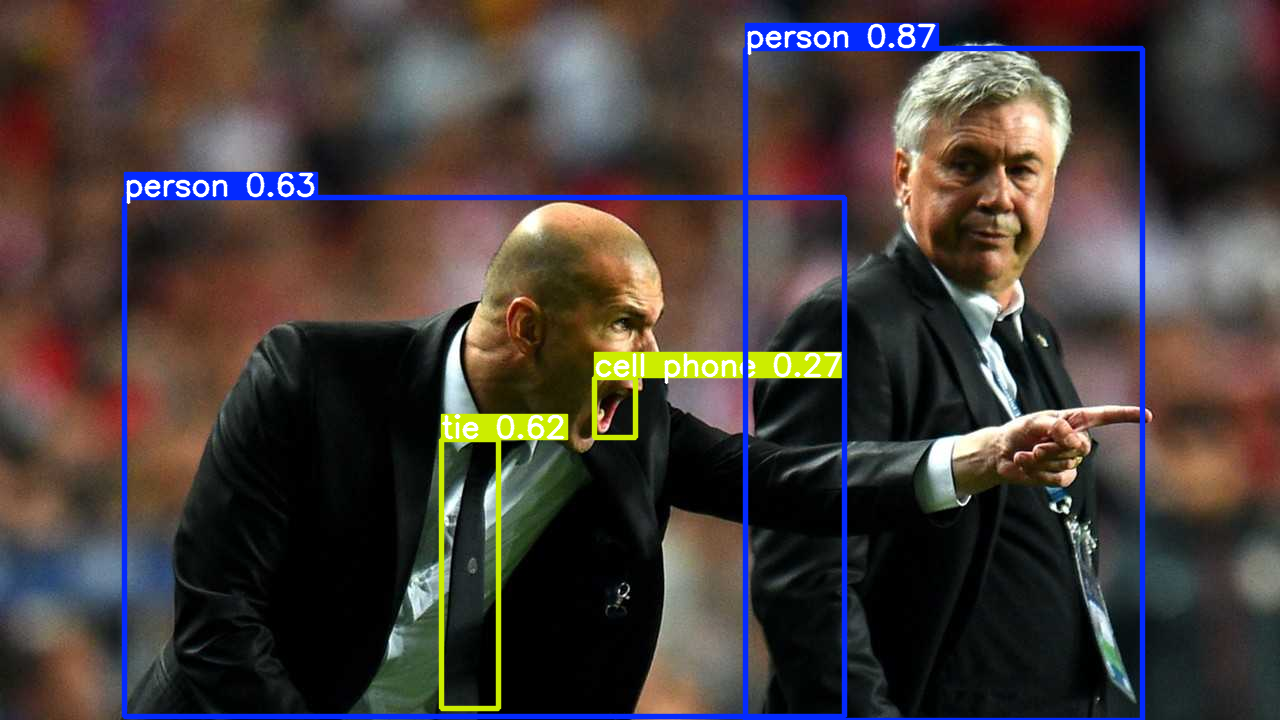

In [28]:
results.print()  # Print results to console
results.show()   # Display results in a window

In [29]:
results.xyxy # Get predictions in xyxy format

[tensor([[7.45579e+02, 4.84703e+01, 1.14269e+03, 7.20000e+02, 8.68910e-01, 0.00000e+00],
         [1.24744e+02, 1.97335e+02, 8.44397e+02, 7.16651e+02, 6.30325e-01, 0.00000e+00],
         [4.41239e+02, 4.39351e+02, 4.98381e+02, 7.08571e+02, 6.16793e-01, 2.70000e+01],
         [5.94082e+02, 3.77300e+02, 6.35424e+02, 4.37148e+02, 2.74013e-01, 6.70000e+01]])]

In [30]:
results.xywhn[0]        # Get predictions in xywhn format
results.pandas().xywhn  # Get predictions in pandas DataFrame format

[    xcenter   ycenter     width    height  confidence  class        name
 0  0.737607  0.533660  0.310247  0.932680    0.868910      0      person
 1  0.378571  0.634712  0.562229  0.721272    0.630325      0      person
 2  0.367039  0.797168  0.044642  0.373917    0.616793     27         tie
 3  0.480276  0.565589  0.032298  0.083121    0.274013     67  cell phone]

## Raw predictions

Above, you have already gotten the results after applying Non-Max Suppression (NMS) and thresholding.
The model outputs a list of predictions, which are the bounding boxes (bboxes) around the detected objects.

In this task, you will visualize the raw predictions and implement the NMS and thresholding yourself.

In [31]:
# Here are some additional attributes you can check for the YOLOv5 model
print(yolo_model.conf) # NMS confidence threshold
print(yolo_model.iou)  # NMS IoU threshold

0.25
0.45


Below is the code to load the image into tensor and run `yolo_model.model(image_tensor)` to get the raw predictions.

This will give you a tensor of shape `(1, num_boxes, 85)`, where `num_boxes` is the number of detected boxes and 85 is the number as follows: 4 coordinates of the box, 1 objectness score, and 80 class scores.

In [32]:
import numpy as np
import cv2

response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")
image_np = np.array(image)  # Convert PIL image to NumPy array

# Letterbox resize to 640x640 (preserve aspect ratio with padding)
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114)):
    shape = im.shape[:2]  # current shape [height, width]
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    dw = new_shape[1] - new_unpad[0]
    dh = new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2
    im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im

img_letterboxed = letterbox(image_np)
img_tensor = torch.from_numpy(img_letterboxed).permute(2, 0, 1).float() / 255.0  # HWC → CHW and normalize
img_tensor = img_tensor.unsqueeze(0).to(device)

# Inference without NMS
with torch.no_grad():
    raw_preds = yolo_model.model(img_tensor)  # tensor of shape [1, 25200, 85]

print("Raw prediction shape:", raw_preds.shape)

Raw prediction shape: torch.Size([1, 25200, 85])


# Setup

## Imports

In [33]:
%matplotlib inline

In [34]:
import torch
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Problem
1. (**0.25p**) Please describe the output tensor and how to interpret it. Especially, explain the meaning of the 5th number, i.e. the objectness score. How is it calculated and related to the class scores?
2. **1p**  Implement the NMS and thresholding yourself.
3. **1p**  Visualize the raw predictions and the predictions after NMS and thresholding.
4. (**0.25p**) Compare the results with the original predictions.
5. (**0.5p**) Vary IoU threshold for NMS and show its effect on detections.
6. (**1p**) Calculate precision, recall, F1 for different IoU thresholds. Calculate `mAP@0.5` (mean Average Precision at an Intersection over Union (IoU) threshold of 0.5) for the model predictions; see https://www.v7labs.com/blog/mean-average-precision
7. (**1p**) Experiment with your own images. Find examples where NMS removes a valid detection (e.g., overlapping people).


### Bonus points:
8. (**1p**) Implement Soft-NMS and compare results; see https://arxiv.org/abs/1704.04503
Does it help in scenes with many overlapping objects?


# Solution

### 1
(**0.25p**) Please describe the output tensor and how to interpret it. Especially, explain the meaning of the 5th number, i.e. the objectness score. How is it calculated and related to the class scores?

Output tensor has size of 85 - it consiste of 4 coordinates of the bounding box, 1 objectness score and 80 class scores.  

The objectness score is a measure of how likely it is that an object is present in the bounding box. It is calculated as the product of the class scores and the confidence score of the bounding box.  
The class scores are the probabilities of each class being present in the bounding box, and the confidence score is a measure of how confident the model is that the bounding box contains an object.  
The objectness score is used to filter out low-confidence detections and keep only high-confidence ones.

### 2
**1p**  Implement the NMS and thresholding yourself.

In [35]:
def non_max_suppression(boxes, scores, threshold):
    """
    Perform non-maximum suppression on bounding boxes 
    (take the best scored box, remove all boxes that overlap with it more than the threshold, repeat)

    Parameters:
    - boxes: List of bounding boxes (x1, y1, x2, y2)
    - scores: List of scores for each bounding box
    - threshold: IoU threshold for suppression

    Returns:
    - List of indices of the remaining boxes after suppression
    """
    
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    indices = np.argsort(scores)[::-1]

    keep = []
    
    while len(indices) > 0:
        i = indices[0]
        keep.append(i)

        # compute IoU with the remaining boxes
        xx1 = np.maximum(x1[i], x1[indices[1:]])
        yy1 = np.maximum(y1[i], y1[indices[1:]])
        xx2 = np.minimum(x2[i], x2[indices[1:]])
        yy2 = np.minimum(y2[i], y2[indices[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter_area = w * h

        iou = inter_area / (area[i] + area[indices[1:]] - inter_area)

        # keep only boxes with IoU less than the threshold
        indices = indices[np.where(iou <= threshold)[0] + 1]

    return keep

### 3
**1p**  Visualize the raw predictions and the predictions after NMS and thresholding.

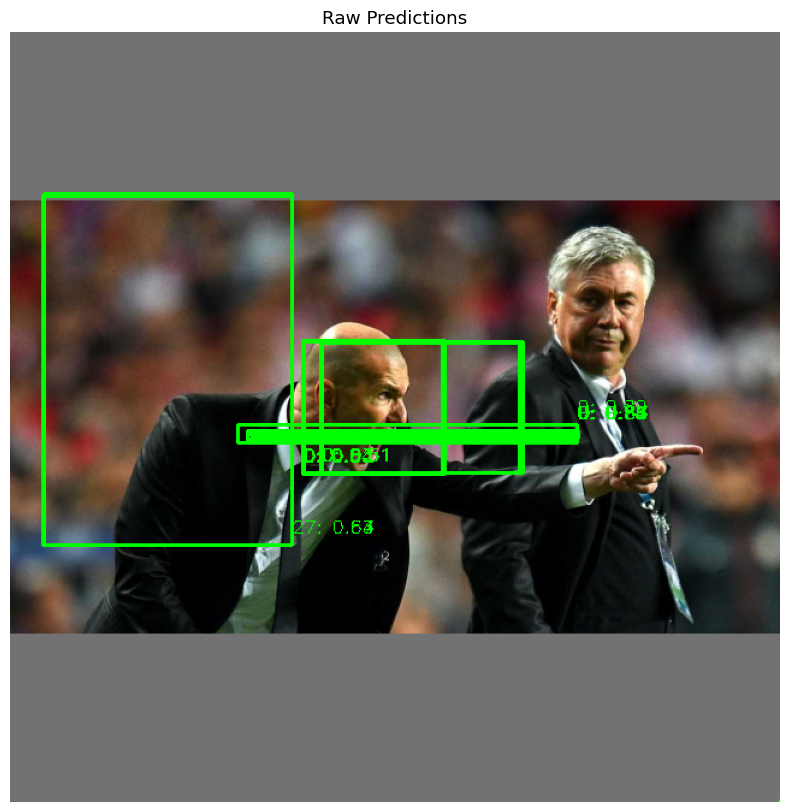

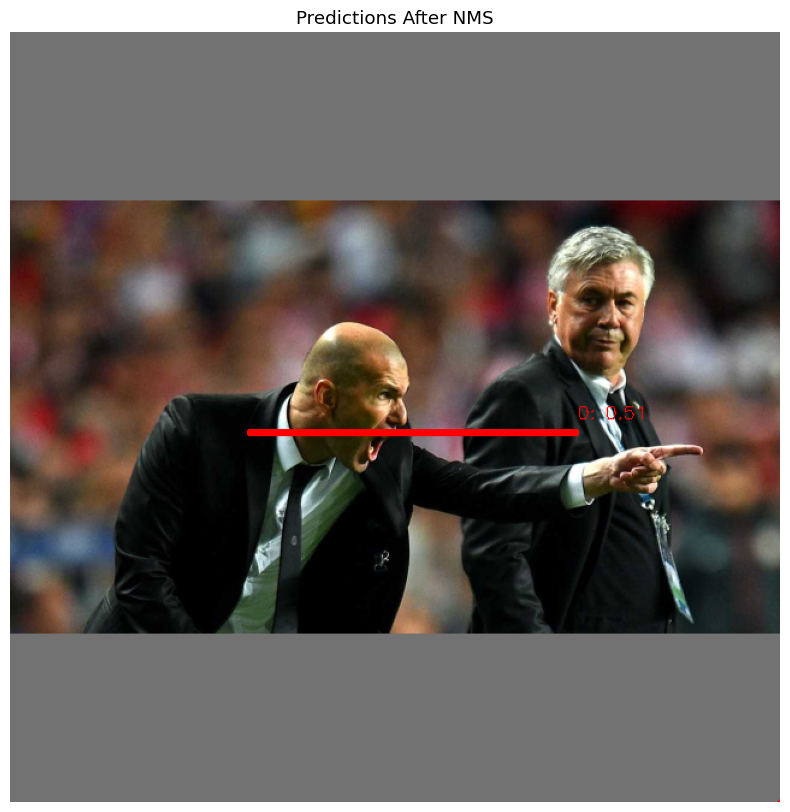

In [39]:
# Visualize raw predictions
for box, score, cls_id in zip(raw_boxes, raw_scores, class_ids_raw):
    if score > confidence_threshold:
        x1, y1, x2, y2 = map(int, box)
        label = f"{cls_id}: {score:.2f}"
        cv2.rectangle(img_vis_raw, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_vis_raw, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.title("Raw Predictions")
plt.imshow(cv2.cvtColor(img_vis_raw, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Visualize predictions after NMS
for box, score, cls_id in zip(nms_boxes, scores_nms, class_ids_nms):
    if score > confidence_threshold:
        x1, y1, x2, y2 = map(int, box)
        label = f"{cls_id}: {score:.2f}"
        cv2.rectangle(img_vis_nms, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(img_vis_nms, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

plt.figure(figsize=(10, 10))
plt.title("Predictions After NMS")
plt.imshow(cv2.cvtColor(img_vis_nms, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### 4
(**0.25p**) Compare the results with the original predictions.

### 5
(**0.5p**) Vary IoU threshold for NMS and show its effect on detections.

### 6
(**1p**) Calculate precision, recall, F1 for different IoU thresholds. Calculate `mAP@0.5` (mean Average Precision at an Intersection over Union (IoU) threshold of 0.5) for the model predictions; see https://www.v7labs.com/blog/mean-average-precision

### 7
(**1p**) Experiment with your own images. Find examples where NMS removes a valid detection (e.g., overlapping people).

### 8 (bonus points)
(**1p**) Implement Soft-NMS and compare results; see https://arxiv.org/abs/1704.04503
Does it help in scenes with many overlapping objects?